<a href="https://colab.research.google.com/github/maxaragon/UBS/blob/main/PyCUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

# Introduction

Here I compare the performance of generating a cloud mask for all sky images using a Python-OpenCV CPU implementation vs a Python-OpenCV-PyCuda GPU approach.

In [ ]:
cd drive/MyDrive/SIRTA

## CPU implementation

In [4]:
def circular_mask(img):
  if len(img.shape) == 3:
    height, width, depth = img.shape
  else:
    height, width = img.shape
  circle_img = np.zeros((height, width), np.uint8)
  mask = cv2.circle(circle_img, (int(width / 2), int(height / 2)), int(width / 2), 1, thickness=-1)
  circular_masked = cv2.bitwise_and(img, img, mask=circle_img)
  return circular_masked

def rgb2gray(rgb):
  (R, G, B) = cv2.split(rgb)
  gray = 0.298*R + 0.587*G + 0.114*B
  gray8 = gray.astype(np.uint8)
  return gray8

def sun_mask(rgb, gray):
  th, W1 = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY); 
  W1 = cv2.erode(W1, None, iterations=6)
  W1 = cv2.dilate(W1, None, iterations=10)
  contours_1, hierarchy = cv2.findContours(W1, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
  contours_1 = max(contours_1, key = cv2.contourArea)
  image_copy_1 = np.zeros(W1.shape)
  W1 = cv2.drawContours(image=image_copy_1, contours=contours_1, contourIdx=-1, color=(255, 255, 255), thickness=20, lineType=cv2.LINE_AA)
  (x, y), radius = cv2.minEnclosingCircle(contours_1)
  center = (int(x), int(y))
  radius = int(radius)
  sun_masked = cv2.circle(rgb, center, int(radius*3), (0, 0, 0), -1)
  return sun_masked

def rgb2rbr(rgb):
  (R, G, B) = cv2.split(rgb)
  ones = np.ones(rgb.shape[:2])
  B = ones + B
  rbr = (R/B)
  return rbr

def cloud_mask(rbr_img):
  retval, T1 = cv2.threshold(rbr_img, 0.87, 256, cv2.THRESH_BINARY)
  return T1 

def fusion(high,low):
  img_fn = [high, low]
  img_list = [cv2.imread(fn) for fn in img_fn]
  img_list = [i[60:710, 180:830] for i in img_list]
  img_list = [circular_mask(i) for i in img_list]
  img_rgb = [cv2.cvtColor(i, cv2.COLOR_RGB2BGR) for i in img_list]
  merge_mertens = cv2.createMergeMertens()
  res_mertens = merge_mertens.process(img_list)
  res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8'); 
  fusion = cv2.cvtColor(res_mertens_8bit, cv2.COLOR_RGB2BGR)
  return fusion

def cloudfind_cpu(img1,img2):
  rgb = fusion(img1,img2)
  gray = rgb2gray(rgb)
  sun = sun_mask(rgb, gray)
  rbr = rgb2rbr(sun)
  clouds = cloud_mask(rbr)
  clouds_m = circular_mask(clouds)
  return rgb, clouds_m


def plot_cpu(rgb,clouds, cpu_time):
  fig,[ax1,ax2] = plt.subplots(1,2, figsize=(10,10))
  fig.suptitle("CPU time: %.5f s" % (cpu_time), y=0.8, fontsize=16)
  fig.tight_layout()
  ax1.imshow(rgb)
  ax2.imshow(clouds)
  for ax in [ax1,ax2]:
    ax.axis('off')
  plt.show()

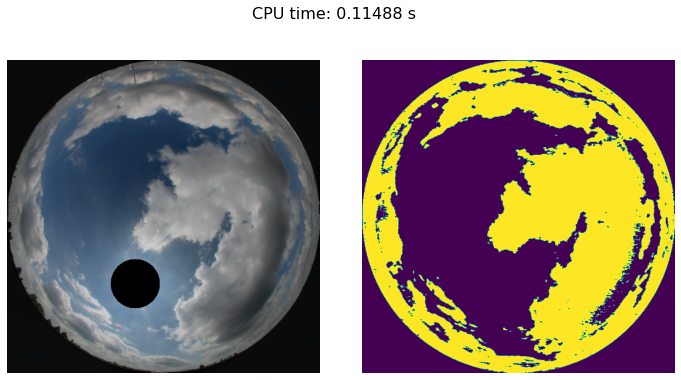

In [11]:
start = time.time()
rgb, clouds = cloudfind_cpu("20220826110000_01.jpg", "20220826110000_03.jpg")
end = time.time()
cpu_time = end-start
plot_cpu(rgb,clouds, cpu_time)

## GPU implementation

In [ ]:
!pip install pycuda

In [8]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [ ]:
cd drive/MyDrive/SIRTA

In [22]:
def circular_mask(img):
  if len(img.shape) == 3:
    height, width, depth = img.shape
  else:
    height, width = img.shape
  circle_img = np.zeros((height, width), np.uint8)
  mask = cv2.circle(circle_img, (int(width / 2), int(height / 2)), int(width / 2), 1, thickness=-1)
  circular_masked = cv2.bitwise_and(img, img, mask=circle_img)
  return circular_masked

def rgb2gray(rgb):
  (R, G, B) = cv2.split(rgb)
  gray = 0.298*R + 0.587*G + 0.114*B
  gray8 = gray.astype(np.uint8)
  return gray8

def sun_mask(rgb, gray):
  th, W1 = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY); 
  W1 = cv2.erode(W1, None, iterations=6)
  W1 = cv2.dilate(W1, None, iterations=10)
  contours_1, hierarchy = cv2.findContours(W1, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
  contours_1 = max(contours_1, key = cv2.contourArea)
  image_copy_1 = np.zeros(W1.shape)
  W1 = cv2.drawContours(image=image_copy_1, contours=contours_1, contourIdx=-1, color=(255, 255, 255), thickness=20, lineType=cv2.LINE_AA)
  (x, y), radius = cv2.minEnclosingCircle(contours_1)
  center = (int(x), int(y))
  radius = int(radius)
  sun_masked = cv2.circle(rgb, center, int(radius*3), (0, 0, 0), -1)
  return sun_masked

def rgb2rbr(rgb):
  (R, G, B) = cv2.split(rgb)
  ones = np.ones(rgb.shape[:2])
  B = ones + B
  rbr = (R/B)
  return rbr

def cloud_mask(rbr_img):
  retval, T1 = cv2.threshold(rbr_img, 0.87, 256, cv2.THRESH_BINARY)
  return T1 

def fusion(high,low):
  img_fn = [high, low]
  img_list = [cv2.imread(fn) for fn in img_fn]
  img_list = [i[60:710, 180:830] for i in img_list]
  img_list = [circular_mask(i) for i in img_list]
  img_rgb = [cv2.cvtColor(i, cv2.COLOR_RGB2BGR) for i in img_list]
  merge_mertens = cv2.createMergeMertens()
  res_mertens = merge_mertens.process(img_list)
  res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8'); 
  fusion = cv2.cvtColor(res_mertens_8bit, cv2.COLOR_RGB2BGR)
  return fusion

def rgb2gray_gpu(rgb):
  
  (R, G, B) = cv2.split(rgb)

  red = R.reshape(422500).astype(np.float32, order='F')
  blue = B.reshape(422500).astype(np.float32, order='F')
  green = G.reshape(422500).astype(np.float32, order='F')

  mod = SourceModule("""
  __global__ void rbd(float *d_result, float *red, float *green, float *blue, int N)
  {
    int i = threadIdx.x + blockIdx.x * blockDim.x;
      while (i < N)
      {
    d_result[i] = red[i]*0.298 + green[i]*0.587 + blue[i]*0.114;
    if(d_result[i]>256)
    {
    d_result[i]=255;
    }
    i = i + blockDim.x * gridDim.x;
      }
  }
  """)

  N = red.size
  result = np.empty_like(red)

  rbd = mod.get_function('rbd')
  rbd(cuda.Out(result), cuda.In(red), cuda.In(green), cuda.In(blue), np.uint32(N), block=(1024,1,1), grid=(64,1,1))

  grey = np.reshape(result,(650,650)).astype(np.uint8)
  return grey

def rgb2rbr_gpu(rgb):
  
  (R, G, B) = cv2.split(rgb)
  w, h = rgb.shape[:2]
  ones = np.ones(rgb.shape[:2])
  B = ones + B

  red = R.reshape(422500).astype(np.float32, order='F')
  blue = B.reshape(422500).astype(np.float32, order='F')

  mod = SourceModule("""
  __global__ void rbd(float *d_result, float *red, float *blue, int N)
  {
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    d_result[i] = red[i] / blue[i];
  }
  """)

  N = red.size
  result = np.empty_like(red)

  rbd = mod.get_function('rbd')
  rbd(cuda.Out(result), cuda.In(red), cuda.In(blue), np.uint32(N), block=(w,1,1), grid=(h,1,1))

  rbr = np.reshape(result,(650,650)).astype(np.float32)
  return rbr

def plot_gpu(rgb,clouds, gpu_time):
  fig,[ax1,ax2] = plt.subplots(1,2, figsize=(10,10))
  fig.suptitle("GPU time: %.5f s" % (gpu_time), y=0.8, fontsize=16)
  fig.tight_layout()
  ax1.imshow(rgb)
  ax2.imshow(clouds)
  for ax in [ax1,ax2]:
    ax.axis('off')
  plt.show()

def cloudfind_gpu(img1,img2):
  rgb = fusion(img1,img2)
  gray = rgb2gray_gpu(rgb)
  sun = sun_mask(rgb, gray)
  rbr = rgb2rbr_gpu(sun)
  clouds = cloud_mask(rbr)
  clouds_m = circular_mask(clouds)
  return rgb, clouds_m

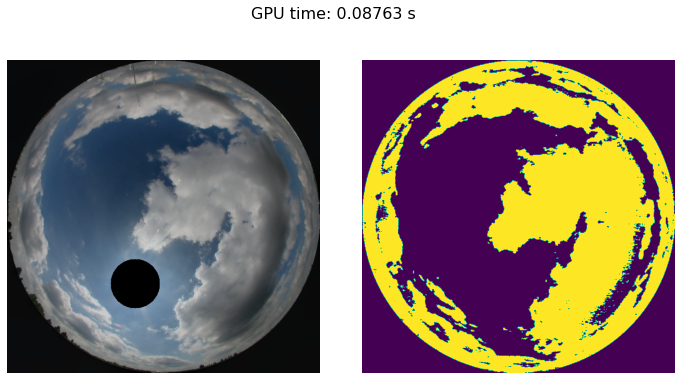

In [24]:
start = time.time()
rgb, clouds = cloudfind_gpu("20220826110000_01.jpg", "20220826110000_03.jpg")
end = time.time()
gpu_time = end-start
plot_gpu(rgb,clouds, gpu_time)

## Conclusion

Running Google Colab Notebook without hardware acceleration results in a lower computational performance compared to the GPU "premium" class. Although only two functions, i.e. rgb to grayscale conversion and red blue ratio were tested under CUDA kernels, the GPU implementation outperforms in speed the CPU. For further work I will try to implement the exposure fusion, and rgb split in PyCuda since these two algorithms are the most memory-time consuming.

CPU time: 0.11488 seconds

GPU time: 0.08763 seconds